## Take a bunch of runs and re-do them with 

In [3]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
# os.chdir("/home/149/ab8992/bottom_near_inertial_waves/automate_experiments")
basepath = Path.cwd().absolute()

import autolib as al
# from dask.distributed import Client
# client = Client()
# client

## Make common forcing

In [10]:
import autolib as al
import numpy as np
import xarray as xr

### COMMON ACROSS ALL EXPERIMENTS. 
##########################################################
nlayers = 20             # number of layers
Lx = 4000                # domain zonal extent [km]
Ly = 1000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(-Lx/2, Lx/2, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
ninterf = nlayers + 1    # number of interfaces
interfaces = np.arange(0,  ninterf)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
overrides = ["ADIABATIC = True",
             "RHO_0 = 1027.0",
             f"NJGLOBAL={ny}",
             f"NIGLOBAL={nx}",
             f"LENLON = {Lx}.0",
             f"WESTLON = -{Lx//2}.0",
             f"LENLAT = {Ly}.0",
             f"WESTLAT = -{Ly//2}.0"]
default_dir = "default_rundir"


## Default values when unperturbed
default_height = 500 # m
default_forcing_latwidth = 300 # km
default_duration = 5 # hours
default_layerdensities = np.linspace(1027,1029,nlayers) ## This is the default stratification
default_strength = 1
default_ridge_width = 12.5 # km


## Value s from first pass! 
## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.25,1.5,2,3,4,0.001,0.01,6]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750,1000,1250,1500,2000] + [500,650,700]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] + [7,8,12,14,15,16,20] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10] + [5,6,7,8,9]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] + [75,125,150,300,400,500,600,700,800,1000]

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000] + [250,400]

STRESS_X = al.windstress_gaussian(nx = nx,ny = ny)
eta_ridge = al.eta_gaussian_hill(
        nlayers=nlayers,
        ridge=True,
        nx = nx,
        ny = ny,
        )
   
al.save_inputdata(
    x,
    y,
    STRESS_X,
    STRESS_X * 0,
    eta_ridge,
    "common",
    )

## Save the common wind forcing
al.save_inputdata(x,y,STRESS_X,STRESS_X * 0,eta_ridge,"common")


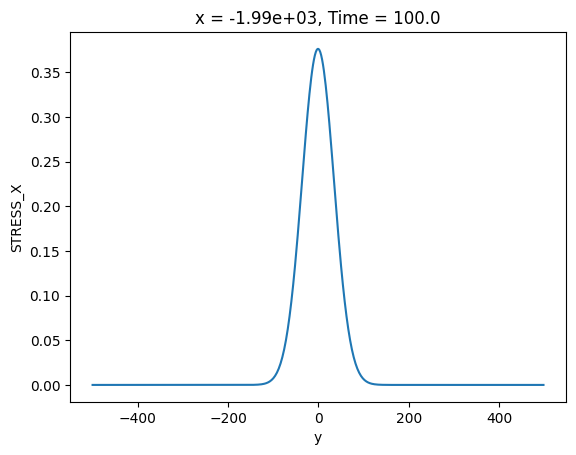

In [11]:
xstress = xr.open_dataset("inputdir/common/storm_windstress.nc").STRESS_X
topo = xr.open_dataset("inputdir/common/driver-layers-topo-densities.nc")
xstress.isel(Time = 50,x = 5).plot()

## Making each set of forcing files

| Experiment | Method|
| --- |---|
| Topo Height | Open default and multiply
| Topo Width | Remake
| Forcing Width | Remake
| Strat | Remake
| Duration | Remake 
| Strength | Open default and multiply

In [3]:
## Iterate over topog type and nlayers
from importlib import reload
# reload(al)

def set_si_coords(array):
    return array.assign_coords({"time":("time",array.time.values * 60),
                             "xq":("xq",array.xq.values * 1000),
                             "xh":("xh",array.xh.values * 1000),
                             "yh":("yh",array.yh.values * 1000),
                             "yq":("yq",array.yq.values * 1000)
    })



class expt:
    def __init__(self,x,y,nlayers,variable,var_value,topo,common):
        self.nlayers = nlayers
        self.variable = variable
        self.var_value = var_value
        self.topo = topo
        self.common = common
        self.x = x
        self.y = y
        self.runname = f"{self.variable}_{self.topo}_{self.nlayers}layer_{self.variable}-{self.var_value}"
        self.exptname = f"{self.variable}_{self.topo}_{self.nlayers}layer"

        if not os.path.exists(f"/home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{self.exptname}/{self.runname}"):
            os.makedirs(f"/home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{self.exptname}/{self.runname}")

        subprocess.run(f"ln -s /g/data/v45/ab8992/mom6_channel_configs/{expt_suite_name}/{self.exptname}/{self.runname} /home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{self.exptname}/{self.runname}/inputdir",shell=True)
    
    def make_topo(self):
        if self.common == "windforcing":
            ## Make topog file
            ridge = self.topo == "ridge"
            eta = al.eta_gaussian_hill(
                nlayers=self.nlayers,
                ridge=ridge,
                nx = len(self.x),
                ny = len(self.y),
                **{self.variable : self.var_value}
                )

            al.save_topo(self.x,
                 self.y,
                 None,
                 None,
                 eta,
                 f"/{expt_suite_name}/{self.exptname}/{self.runname}",
                 savewind = False,
                 **{self.variable : self.var_value}
                 )
        elif self.common == "topog":
            ## Make and save wind stress
            STRESS_X = al.windstress_gaussian(nx = len(self.x),
                                           ny = len(self.y),
                                           reverse = True,
                                           **{self.variable : self.var_value})
            al.save_topo(self.x,
                self.y,
                STRESS_X,
                STRESS_X * 0,
                np.zeros((1,len(self.y),len(self.x))),
                f"/{expt_suite_name}/{self.exptname}/{self.runname}",
                savedensities = False
                )
        return
    
    def setup(self,overrides = None,walltime = None,default_dir = None,run_duration = 10,forcing_path=None):
        print("SETUP: " + self.runname)


        if forcing_path == None:
            forcing_path = f"{expt_suite_name}/{self.exptname}/{self.runname}" 

        if self.common == "topog":
            common_forcing_path = f"{expt_suite_name}_common_{self.topo}_{self.nlayers}layers"
        elif self.common == "windforcing":
            common_forcing_path = f"{expt_suite_name}_common_wind"
        al.setup_mom6(f"{expt_suite_name}/{self.exptname}/{self.runname}",
                    forcing_path,
                    walltime = walltime,
                    overrides = overrides + [f"NK={self.nlayers}"],
                    common_forcing = f"{expt_suite_name}/common/{common_forcing_path}",
                    default_dir=default_dir,
                    run_duration = run_duration
                    )   

    def run(self):
        print("RUNNING: " + self.runname)
        al.run_mom6(f"{self.exptname}/{self.runname}")   
        return
    def set_noforcing(self):
        subprocess.run(
            "/home/149/ab8992/bottom_near_inertial_waves/automated/forcing_off.sh",
            cwd = f"/home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{self.exptname}/{self.runname}")        
        return
    def fastrun(self):
        subprocess.run(
            "payu run -f",shell= True,cwd = f"/home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{self.exptname}/{self.runname}"
        )
        return


    def process_output(self,xrange = [-100,100], yrange = [-1510,-1490],tlim = None,outpath = None,integrate = True):
        """
        Copy of the baroclinic EF function in autolib. This time just return the fluxes along the boundaries of provided domain rather than 
        calculate huge array of EF
        """
        datapath = f"/home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{self.exptname}/{self.runname}"

        e = xr.open_mfdataset(datapath +  "/archive/output00*/e_10min.nc",decode_times = False,parallel = True,chunks = {"zl":1,"time":50}).sel(
            xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )
        u = xr.open_mfdataset(datapath +  "/archive/output00*/u_10min.nc",decode_times = False,parallel = True,chunks = {"zl":1,"time":50}).sel(
            xq = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )
        # v = xr.open_mfdataset(datapath +  "/archive/output00*/v_10min.nc").sel(
        #     xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
        #         time = slice(0,tlim)
        #     )
        tau = xr.open_mfdataset(datapath +  "/archive/output00*/taux_10min.nc",decode_times = False,parallel = True,chunks = {"time":50}).sel(
            xq = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )

        # v = data.v.interp(yq = data.u.yh).drop("yq").sel(xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1]))
        e = e.e.assign_coords({"time":("time",e.time.values * 60),
                                "xh":("xh",e.xh.values * 1000),
                                "yh":("yh",e.yh.values * 1000)
            }).astype(float)
        tau = tau.taux.assign_coords({"time":("time",tau.time.values * 60),
                                "xq":("xq",tau.xq.values * 1000),
                                "yh":("yh",tau.yh.values * 1000)
            }).interp(xq = e.xh).drop("xq").astype(float)
        u = u.u.assign_coords({"time":("time",u.time.values * 60),
                                "xq":("xq",u.xq.values * 1000),
                                "yh":("yh",u.yh.values * 1000)
            }).interp(xq = e.xh).drop("xq").astype(float)


        # e = (e).persist()
        u = u.persist()
        # tau = tau.persist()

        # densities = u.zl.load()
        # thickness = al.get_thickness(e,densities)
        # u_dwa = al.dwa(thickness,u)
        # # v_dwa = dwa(thickness,v)
        # Mg = al.montgomery(e,densities)
        # Mgprime = Mg - al.dwa(thickness,Mg)

        # uprime = u - u_dwa
        # vprime = v - v_dwa

        # conv = (1027 * Mgprime.differentiate("xh") * thickness * u_dwa).sum("zl")

        wind_work = (tau * u.isel(zl = 0)).isel(
            time = slice(0,500),
            ).sel(xh = slice(-25000,25000)).integrate("xh").integrate("yh")

        # EF_zonal = (1027 * Mgprime * uprime * thickness).sum("zl").isel(xh = [0,-1]).rename({"xh":"xi"}).integrate("yh")
        # EF_merid = (1027 * Mgprime * vprime * thickness).sum("zl").isel(yh = [0,-1]).rename({"yh":"yi"})

        wind_work = wind_work.integrate("time")
        data = xr.Dataset(
            data_vars = {
                        # "EF_zonal":EF_zonal,
                        "wind_work":wind_work
                        # "u":u,
                        # "e":e,
                        # "thickness":thickness,## Comment these out to return to what I originally output
                        # "Mgprime":Mgprime, 
                        # "uprime":uprime
                        }
        )
        data.wind_work.attrs["units"] = "Integrated over meridional extent and 50km zonally"
        
        data.to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/{expt_suite_name}/{self.runname}")
        return data
    
    ## If you screw up, run to delete all outputs and start from scratch
    def reset(self):
        try:
            subprocess.run(f"rm /home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{self.exptname}/{self.runname}/archive/* -rf",shell = True)
            subprocess.run(f"rm /home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{self.exptname}/{self.runname}/* -rf",shell = True)
        except:
            print(self.runname)
    


## Make the inputs for each experiment

In [4]:
expts = []

k = [5]
topos = ["ridge","hill"]

k = [20]
topos = ["ridge"]

for nlayers in k:
    for topo in topos:
        # # HEIGHTS
        # for height in heights:
        #     run = expt(x,y,nlayers,"height",height,topo,"windforcing")

        #     # run.make_topo()
        #     run.setup(default_dir=default_dir,overrides=overrides)
        #     # run.run()
        #     expts.append(run)

        # ## STRATS
        # for strat in strats:
        #     run = expt(x,y,nlayers,"strat",strat,topo,"windforcing")
        #     # run.make_topo()
        #     run.setup(default_dir=default_dir,overrides=overrides)
        #     # run.run()
        #     expts.append(run)

        # ## TOPO WIDTHS
        # for width in widths:
        #     run = expt(x,y,nlayers,"width",width,topo,"windforcing")

        #     # run.make_topo()
        #     run.setup(default_dir=default_dir,overrides=overrides)
        #     # run.run()
        #     expts.append(run)


        ## WIND FORCING EXPERIMENTS
        # Here we recycle the wind forcing since it doesn't change with topo
        ## FORCING WIDTHS
        for forcing_width in forcing_widths:
            run = expt(x,y,nlayers,"forcing_latwidth",forcing_width,topo,"topog")

            # run.make_topo()
            
            run.setup(default_dir=default_dir,overrides=overrides,
                    # forcing_path=f"juneruns/june_forcing_latwidth_ridge_5layer/june_forcing_latwidth_ridge_5layer_forcing_latwidth-{forcing_width}"
                    )
            
            expts.append(run)

        ## DURATIONS
        for duration in durations:
            run = expt(x,y,nlayers,"duration",duration,topo,"topog")

            # run.make_topo()
            run.setup(default_dir=default_dir,overrides=overrides,run_duration = 2 * duration,
                    # forcing_path=f"juneruns/june_duration_ridge_5layer/june_duration_ridge_5layer_duration-{duration}"
                    )
            
            expts.append(run)

        ## STRENGTHS
        for strength in strengths:
            run = expt(x,y,nlayers,"strength",strength,topo,"topog")

            # run.make_topo()
            run.setup(default_dir=default_dir,overrides=overrides,
                    # forcing_path=f"juneruns/june_strength_ridge_5layer/june_strength_ridge_5layer_strength-{strength}"
                    )
            
            expts.append(run)

ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-25/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-25': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-50/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-50': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-75/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-75': File exists


SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-25
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-50
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-75


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-100/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-100': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-150/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-150': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-175/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-175': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-200/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-200': File exists


SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-100
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-150
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-175
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-200


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-300/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-300': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-500/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-500': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-800/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-800': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-1000/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-1000': File exists
ln: failed

SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-300
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-500
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-800
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-1000
SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-250


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/forcing_latwidth_ridge_20layer/forcing_latwidth_ridge_20layer_forcing_latwidth-400/inputdir/forcing_latwidth_ridge_20layer_forcing_latwidth-400': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-0.5/inputdir/duration_ridge_20layer_duration-0.5': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-1/inputdir/duration_ridge_20layer_duration-1': File exists


SETUP: forcing_latwidth_ridge_20layer_forcing_latwidth-400
SETUP: duration_ridge_20layer_duration-0.5
SETUP: duration_ridge_20layer_duration-1


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-2/inputdir/duration_ridge_20layer_duration-2': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-3/inputdir/duration_ridge_20layer_duration-3': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-4/inputdir/duration_ridge_20layer_duration-4': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-5/inputdir/duration_ridge_20layer_duration-5': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-6/inputdir/duration_ridge_20layer_duration-6

SETUP: duration_ridge_20layer_duration-2
SETUP: duration_ridge_20layer_duration-3
SETUP: duration_ridge_20layer_duration-4
SETUP: duration_ridge_20layer_duration-5
SETUP: duration_ridge_20layer_duration-6


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-8.7/inputdir/duration_ridge_20layer_duration-8.7': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-10/inputdir/duration_ridge_20layer_duration-10': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-7/inputdir/duration_ridge_20layer_duration-7': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-8/inputdir/duration_ridge_20layer_duration-8': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-12/inputdir/duration_ridge_20layer_dur

SETUP: duration_ridge_20layer_duration-8.7
SETUP: duration_ridge_20layer_duration-10
SETUP: duration_ridge_20layer_duration-7
SETUP: duration_ridge_20layer_duration-8
SETUP: duration_ridge_20layer_duration-12


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-14/inputdir/duration_ridge_20layer_duration-14': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-15/inputdir/duration_ridge_20layer_duration-15': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-16/inputdir/duration_ridge_20layer_duration-16': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/duration_ridge_20layer/duration_ridge_20layer_duration-20/inputdir/duration_ridge_20layer_duration-20': File exists


SETUP: duration_ridge_20layer_duration-14
SETUP: duration_ridge_20layer_duration-15
SETUP: duration_ridge_20layer_duration-16
SETUP: duration_ridge_20layer_duration-20


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-0.1/inputdir/strength_ridge_20layer_strength-0.1': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-0.2/inputdir/strength_ridge_20layer_strength-0.2': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-0.5/inputdir/strength_ridge_20layer_strength-0.5': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-0.75/inputdir/strength_ridge_20layer_strength-0.75': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-1/inputdir/strength_ridge_

SETUP: strength_ridge_20layer_strength-0.1
SETUP: strength_ridge_20layer_strength-0.2
SETUP: strength_ridge_20layer_strength-0.5
SETUP: strength_ridge_20layer_strength-0.75
SETUP: strength_ridge_20layer_strength-1


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-1.25/inputdir/strength_ridge_20layer_strength-1.25': File exists


SETUP: strength_ridge_20layer_strength-1.25


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-1.5/inputdir/strength_ridge_20layer_strength-1.5': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-2/inputdir/strength_ridge_20layer_strength-2': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-3/inputdir/strength_ridge_20layer_strength-3': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-4/inputdir/strength_ridge_20layer_strength-4': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-10/inputdir/strength_ridge_20layer_stren

SETUP: strength_ridge_20layer_strength-1.5
SETUP: strength_ridge_20layer_strength-2
SETUP: strength_ridge_20layer_strength-3
SETUP: strength_ridge_20layer_strength-4
SETUP: strength_ridge_20layer_strength-10


ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-5/inputdir/strength_ridge_20layer_strength-5': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-6/inputdir/strength_ridge_20layer_strength-6': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-7/inputdir/strength_ridge_20layer_strength-7': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-8/inputdir/strength_ridge_20layer_strength-8': File exists
ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/revision/strength_ridge_20layer/strength_ridge_20layer_strength-9/inputdir/strength_ridge_20layer_strength-9

SETUP: strength_ridge_20layer_strength-5
SETUP: strength_ridge_20layer_strength-6
SETUP: strength_ridge_20layer_strength-7
SETUP: strength_ridge_20layer_strength-8
SETUP: strength_ridge_20layer_strength-9


In [5]:
## Run experiments in first instance

## Suddenly every single experiment now gets the 'drops below bathy t' error?? 
## Running single test case from output000 WORKS but copying from default doesn't??
for i in expts:
    path = f"/home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{i.exptname}/{i.runname}"
    if not os.path.exists(path + "/archive/output000"):
        print(i.runname)
        # i.run()

In [8]:
# wait for 10s
import time


In [7]:
## Rerun with no forcing

# time.sleep(3600 * 1.5)

ycount = 0
ncount = 0
for i in expts:
    path = f"/home/149/ab8992/bottom_near_inertial_waves/{expt_suite_name}/{i.exptname}/{i.runname}"
    if not os.path.exists(path + "/archive/output001") and os.path.exists(path + "/archive/output000"):
        print(i.runname,"True")
        i.set_noforcing()
        i.fastrun()
    # else:
    #     print(i.runname,"False")






forcing_latwidth_ridge_20layer_forcing_latwidth-25 True
112505196.gadi-pbs
payu: warning: Job request includes 47 unused CPUs.
payu: warning: CPU request increased from 625 to 672
Loading input manifest: manifests/input.yaml
Loading restart manifest: manifests/restart.yaml
Loading exe manifest: manifests/exe.yaml
payu: Found modules in /opt/Modules/v4.3.0
qsub -q normal -P nm03 -l walltime=21600 -l ncpus=672 -l mem=2688GB -N forcing_latwidt -l wd -j n -v PAYU_PATH=/g/data/hh5/public/apps/miniconda3/envs/analysis3/bin,PAYU_FORCE=True,MODULESHOME=/opt/Modules/v4.3.0,MODULES_CMD=/opt/Modules/v4.3.0/libexec/modulecmd.tcl,MODULEPATH=/g/data/hh5/public/modules:/etc/scl/modulefiles:/opt/Modules/modulefiles:/opt/Modules/v4.3.0/modulefiles:/apps/Modules/modulefiles -W umask=027 -l storage=gdata/hh5+gdata/v45+scratch/v45 -- /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/bin/python3.10 /g/data/hh5/public/apps/miniconda3/envs/analysis3/bin/payu-run
forcing_latwidth_ridge_20layer_forcing_l

## Process outputs (with EF, same as earlier)

In [8]:
from IPython.display import clear_output


todo = []

for i in expts:
    if not os.path.exists(f"/g/data/v45/ab8992/bottom_iwbs/juneresults/{i.runname}"):
        todo.append(i)

tot = len(todo)

curr = 0

for i in todo:
    if not os.path.exists(f"/g/data/v45/ab8992/bottom_iwbs/juneresults/{i.runname}"):
        clear_output()
        print(f"{curr}/{tot} {100 * curr/tot}% complete. \t\t Processing {i.runname}. ")
        i.process_output()
        curr += 1

0/60 0.0% complete. 		 Processing june_height_hill_5layer_height-350. 


## Domain with shorter x extent to test reentering wave theory

In [8]:


nlayers = 20             # number of layers
Lx = 2000                # domain zonal extent [km]
Ly = 1000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(0, Lx, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
STRESS_X = al.windstress_gaussian(
    nx = nx,
    ny = ny,
    duration=default_duration,
    strength=default_strength,
    forcing_latwidth = default_forcing_latwidth,
    reverse = True)

eta_ridge = al.eta_gaussian_hill(
    nlayers=20,
    ridge=True,
    nx = nx,
    ny = ny,
    height = default_height
    )


al.save_topo(x,
            y,
            None,
            None,
            eta_ridge,
            f"/{expt_suite_name}/common/{expt_suite_name}_short_x_test_{nlayers}layers",
            savewind = False)

## Save the common wind forcing
al.save_topo(x,y,STRESS_X,STRESS_X * 0,eta_ridge,f"/{expt_suite_name}/common/{expt_suite_name}_short_x_test_common_wind",savedensities = False)


run = expt(x,y,nlayers,"strength",42,"ridge","topog")

            # run.make_topo()
            
run.setup(default_dir=default_dir,overrides=overrides,
        # forcing_path=f"juneruns/june_forcing_latwidth_ridge_5layer/june_forcing_latwidth_ridge_5layer_forcing_latwidth-{forcing_width}"
        )

SETUP: strength_ridge_20layer_strength-42


In [4]:
run.set_noforcing()

NameError: name 'run' is not defined